This is a tutorial on how to train a sequence-to-sequence model that uses the nn.Transformer module.

PyTorch 1.2 release includes a standard transformer module based on the paper Attention is All You Need. The transformer model has been proved to be superior in quality for many sequence-to-sequence problems while being more parallelizable. The nn.Transformer module relies entirely on an attention mechanism (another module recently implemented as nn.MultiheadAttention) to draw global dependencies between input and output. The nn.Transformer module is now highly modularized such that a single component (like nn.TransformerEncoder in this tutorial) can be easily adapted/composed.

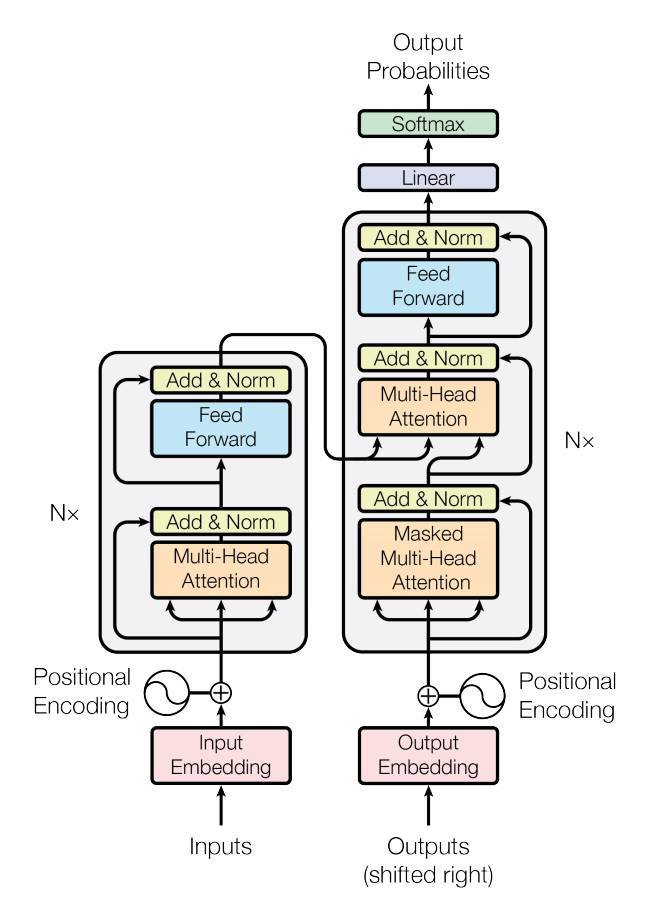

# Define the model

In this tutorial, we train nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). The nn.TransformerEncoder consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in nn.TransformerEncoder are only allowed to attend the earlier positions in the sequence. For the language modeling task, any tokens on the future positions should be masked. To have the actual words, the output of nn.TransformerEncoder model is sent to the final Linear layer, which is followed by a log-Softmax function.

In [10]:
import math
import torch
from torch import nn
from torch.nn import TransformerEncoderLayer, TransformerEncoder
import torch.nn.functional as F

PositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(
            mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

# Load and batch data

This tutorial uses torchtext to generate Wikitext-2 dataset. The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. Starting from sequential data, the batchify() function arranges the dataset into columns, trimming off any tokens remaining after the data has been divided into batches of size batch_size. For instance, with the alphabet as the sequence (total length of 26) and a batch size of 4, we would divide the alphabet into 4 sequences of length 6:

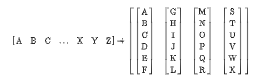

In [13]:
import io
import torch
from torchtext.utils import extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [14]:
test_filepath, valid_filepath, train_filepath = extract_archive(
    './wikitext-2-v1.zip')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(
    map(tokenizer, iter(io.open(train_filepath, encoding="utf8"))))


def data_process(raw_text_iter):
    data = [
        torch.tensor([vocab[token] for token in tokenizer(item)],
                     dtype=torch.long) for item in raw_text_iter
    ]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))


train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)


batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

36718lines [00:01, 21804.36lines/s]


# Functions to generate input and target sequence

get_batch() function generates the input and target sequence for the transformer model. It subdivides the source data into chunks of length bptt. For the language modeling task, the model needs the following words as Target. For example, with a bptt value of 2, we’d get the following two Variables for i = 0:

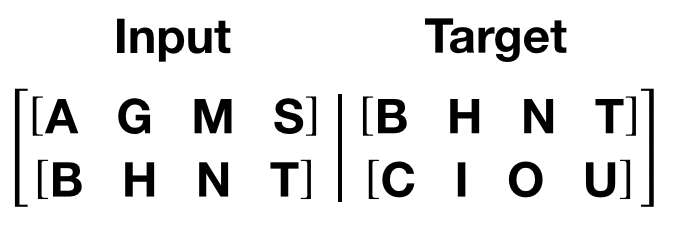

It should be noted that the chunks are along dimension 0, consistent with the S dimension in the Transformer model. The batch dimension N is along dimension 1.

In [15]:
bptt = 35


def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i + seq_len]
    target = source[i + 1:i + 1 + seq_len].reshape(-1)
    return data, target

# Initiate an instance

The model is set up with the hyperparameter below. The vocab size is equal to the length of the vocab object.

In [16]:
ntokens = len(vocab.stoi)  # the size of vocabulary
emsize = 200  # embedding dimension
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0.2  # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers,
                         dropout).to(device)

# Run the model

CrossEntropyLoss is applied to track the loss and SGD implements stochastic gradient descent method as the optimizer. The initial learning rate is set to 5.0. StepLR is applied to adjust the learn rate through epochs. During the training, we use nn.utils.clip_grad_norm_ function to scale all the gradient together to prevent exploding.

In [17]:
criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time


def train():
    model.train()  # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(
                data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                      epoch, batch,
                      len(train_data) // bptt,
                      scheduler.get_lr()[0], elapsed * 1000 / log_interval,
                      cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


def evaluate(eval_model, data_source):
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(
                    data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

In [18]:
best_val_loss = float("inf")
epochs = 3  # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

e:\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:350: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 22.46 | loss  8.23 | ppl  3742.58
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 19.22 | loss  6.93 | ppl  1024.22
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 19.40 | loss  6.47 | ppl   646.39
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 19.37 | loss  6.32 | ppl   552.96
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 19.79 | loss  6.20 | ppl   491.47
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 19.38 | loss  6.16 | ppl   474.67
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 19.88 | loss  6.12 | ppl   452.95
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 19.46 | loss  6.11 | ppl   448.76
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 19.44 | loss  6.02 | ppl   411.59
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 19.36 | loss  6.02 | ppl   413.00
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 19.37 | loss  5.91 | ppl   366.92
| epoch   1 |  2400/ 

# Evaluate the model with the test dataset

Apply the best model to check the result with the test dataset.

In [19]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.47 | test ppl   238.31
